# {<[(BRACKETS)]>}

The purpose of this toy project is to investigate how different model architectures deal with a simple classification task.

## PREMISE

We will be building classification models to predict whether a sequence of bracket symbols is "gramatically" correct. 

### Rules

We define the grammar in the following way:
- All bracket symbols are grouped into pairs, with one opening and one closing, eg: ```()```, ```[]```, ```{}```, ```<>```.
- Every bracket opened should be closed. No closing bracket can exist if its corresponding opening hasn't come earlier. Eg ```(())```, ```[()]```, ```({})``` are correct; ```)(```, ```{}}```, ```{{{}``` are not.
- Brackets are opened and closed in a last in-first out manner, ie any closing bracket must correspond to the most recent yet unclosed opening one. Eg ```[{({})}]()``` is correct, ```[(])``` isn't.

These rules can be applied to a sequence of any length. Obviously, all correct sequences have an even number of characters. Since we want our models to be able to learn rules applicable to sequences of any length, we should make some adjustments in terms of sequence representation. Since some models will require a constant input length (eg a vanilla NN), we introduce a padding symbol. If a sequence is shorter than the maximum lenght (a hyperparameter), it will be padded by adding the necessary number of padding elements (here ```.```) at the end. This necessitates a couple additional grmmar rules:
- The padding elements at the end of a sequence are ignored, and the input is corect if the brackets are correct. Eg ```{}[]....``` is correct because it is the same as ```{}[]```; ```{[]}))...``` is not because ```{[]}))``` isn't
- Sequences in which the padding symbol comes before or inbetween any brackets are considered incorrect. Eg ```{[(...)]}...```, ```[]..()...``` are incorrect even if the brackets themselves are OK. A sequence consisting only of padding and no brackets (```......```) is also considered incorrect.

### The elephant in the room

It has likely already occured to the reader that the task described above can be easily achieved with explicit programming. A simple algorithm can very quickly tell us whether a sequence is correct with 100% accuracy and without the need for training an ML model (which can be costly). Normally, ML is applied to problems where explicit programming does not perform well enough - this is evidently not the case here. 

However, the simplicity of the task has some advantages. Firstly we can quickly and easily generate and label with 100% accuracy an arbitrarily large (subject to combinatorial constrains) datatset. Secondly, as the classification rules are explicit, complete, and relatively simple, we have a better chance of judging whether our models have learned them the way a human would, or are processing the sequences in another way entirely (we should however note the inherent problems with the interpetability of NNs). 

That said, I should state that the purposes of this project are purely pedagogical and exploratory.

## APPROACH

We will be building a series of ML model with increasing complexity and comparing their performance. We will start with "vanilla" neural networks (NNs), comparing width vs depth, and then proceeding to more elaborate and appropriate sequence models such as GRUs, LSTMs, and transformers.

We will be using PyTorch for handling data and buidling/training the models.

In [50]:
# Importing necessary packages

# from random import choices, randint, seed
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import utils as ut

# Setting random seeds for reproducibility

torch.manual_seed(42)
random.seed(42)

In [51]:
ut.SampleCorrect(10)

NameError: name 'choices' is not defined

It is interesting to look at the distribution of sequence lenghts generated by SampleCorrect. As expected, there are more sequences of larger sequence lenght. This is due to combinatorial reasons - note that for example there is only 4 possibilities for n=2 (if we have 4 types of brackets), but the number grows exponentially with n.

## Creating the dataset

We now embark upon building an appropriately sized dataset on which to train and test the model. As random generation of sequences would result in an extremely small number of correct sequences, we will use our ```SampleCorrect()``` utility function to unbias the dataset and allow the model to see a sufficient number of both postive and negative examples.

In [26]:
# Creating the dataset

# Hyperparameters: set of characters and max lenght of sequences
chars = {'(', ')', '[', ']', '{', '}', '<', '>'}
MAX_LEN = 10

# 8000 correct examples
correct = SampleCorrect(8000)

# 2^13 = 8196 random examples; we expect a small amount of duplicates, 
# and a neglible number (if any) of correct sequences
rand = []
# Iterating over possible sequence lenghts
for k in range(MAX_LEN+1):
    # exponential term ensures we generate more of the longer sequences
    while(len(rand)<2**(k+3)): 
        # Rndomly sampling, padding, and appending
        seq = ''.join(choices(list(chars), k=k))
        rand.append(seq + (MAX_LEN - k)*'.')

# Combining correct and random
# Re-labeling in case we randomly generated a correct one 
# -> 100% accuracy in dataset labels
Dataset = list(correct.union(set(rand)))
Labels = [int(IsValid(seq)) for seq in Dataset]

print(f'We have created a dataset of {len(Dataset)} sequences, {sum(Labels)} of which are correct.')

NameError: name 'choices' is not defined

### Exploring the dataset

Let us now see what we have created. We biased (or unbiased - depending on the point of view) our sateset to have roughly half correct examples. The way we have implemented it, this can be tweeked easily and could be treated almost as a dataset hyperparameter. Let us stick with this for now to ensure the model sees enough of both correct and incorrect examples.

It is also useful to check out the distribution of sequence lengths, and whether it is roughly the same for correct and incorrect examples. Note the use of log scales below.

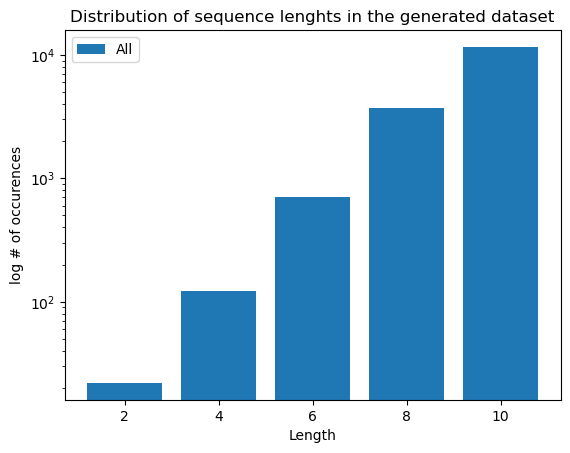

In [92]:
plt.hist(RealLen(Dataset), bins = [1, 3, 5, 7, 9, 11], rwidth=0.8, label='All');
plt.title('Distribution of sequence lenghts in the generated dataset')
plt.xlabel('Length')
plt.yscale('log')
plt.ylabel('log # of occurences')
plt.legend()

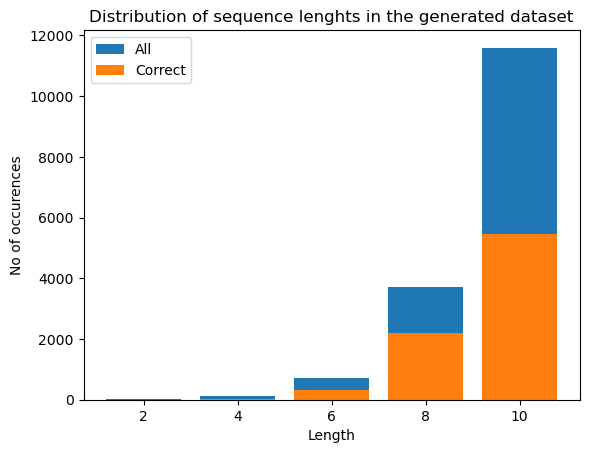

In [93]:
plt.hist(RealLen(Dataset), bins = [1, 3, 5, 7, 9, 11], rwidth=0.8, label='All');
plt.hist(RealLen(correct), bins = [1, 3, 5, 7, 9, 11], rwidth=0.8, label='Correct');
plt.title('Distribution of sequence lenghts in the generated dataset')
plt.xlabel('Length')
plt.ylabel('No of occurences')
plt.legend()

We see the expected exponential growth in the first plot, and not notice any signifficant bias in the second.

## Processing the Dataset 

As of now, we have a list of strings with sequences, and a list of integer labels (1 and 0) for them. To make our dataset compatible with the ML framework that we will be using - PyTorch - we need to change these into the ```torch.tensor``` datatype. During that process, we need to turn our strings of characters into arrays of numbers - so called encoding.

### Splitting into train/dev/test

Additionally, we would like to split our dataset into 3 subsets:
- Training, which we will be using to train the model,
- Development (a.k.a. cross-validation), which we will use to tune hyperparameters and get a sense of the generalisation/overfitting, and finally
- Test, which we will use for an unbiased estimate of our model's performance.

We will be using a 80/10/10 split, which is a common choice for datasets of modest size like ours.

In [94]:
# Creating the encoding dicts
chars.add('.')
dict_size = len(chars)
stoi, itos = {}, {}
for idx, char in enumerate(sorted(list(chars))):
    stoi[char] = float(idx)
    itos[idx] = char

decode = lambda tens: ''.join([itos[i.item()] for i in tens])

# Encoding and splitting into train/dev/test
n1 = int(len(Dataset)*0.8)
n2 = int(len(Dataset)*0.9)

with torch.no_grad():
    Xtr = torch.tensor([[stoi[char] for char in seq] for seq in Dataset][0:n1])
    Xdev = torch.tensor([[stoi[char] for char in seq] for seq in Dataset][n1:n2])
    Xte = torch.tensor([[stoi[char] for char in seq] for seq in Dataset][n2:])
    Ytr = torch.tensor(Labels[0:n1], dtype=torch.float32).reshape(-1, 1)
    Ydev = torch.tensor(Labels[n1:n2], dtype=torch.float32).reshape(-1, 1)
    Yte = torch.tensor(Labels[n2:], dtype=torch.float32).reshape(-1, 1)

It is useful to ensure we have split the dataset in a reasonable way. One easy check we can do is to see if the correct examples have been distributed somewhat evenly:

In [95]:
print(f'Number of correct examples in Train: {int(torch.sum(Ytr).item())}')
print(f'Number of correct examples in Dev: {int(torch.sum(Ydev).item())}')
print(f'Number of correct examples in Test: {int(torch.sum(Yte).item())}')

Number of correct examples in Train: 6348
Number of correct examples in Dev: 838
Number of correct examples in Test: 814


Keeping in mind the Train set is 8 times bigger than the Dev and Test, this distribution of correct examples is reasonable.

Note it is important that the Dev and Test sets come from the same distribution, as we use the former to tune our model, and the latter to determine how well we have tuned it. Changing the train dataset by e.g. adding some amount of randomly generated sequences wouldn't be as much of a problem. For the time being, let is stick with this dataset.

## Model A - shallow neural network

We begin our exploration of model architectures by considering a simple NN, consiting of one Dense layer with ReLU activation, feeding into a single neuron which then uses a sigmoid non-linearity to give a binary classification prediction.

In [96]:
# Building the model

LayerSizes = [16, 1]

model = nn.Sequential(
    nn.Linear(MAX_LEN, LayerSizes[0]),
    nn.ReLU(),
    nn.Linear(LayerSizes[0], LayerSizes[1]),
    nn.Sigmoid()
    )

optimizer = torch.optim.Adam(model.parameters())
model.train=True

### Training the model

We now proceed to train the model on the Train set. We will be recording the training and validation loss at periods to evaluate our model.

In [ ]:
MAX_EPOCHS = 25000
train_losses, dev_losses = [], []
for epoch in range(MAX_EPOCHS):
    outs = model(Xtr)
    loss = F.binary_cross_entropy(outs, Ytr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        train_losses.append(loss.item())
        with torch.no_grad():
            dev_pred = model(Xdev)
            dev_loss = F.binary_cross_entropy(dev_pred, Ydev)
            dev_losses.append(dev_loss.item())

### Evaluating the model

A good first step for gaining insight into how our model is doing is to look at the change in training and validation loss. If the loss is decreasing, then our model is learning, i.e. improving its predictions. The difference between the training and validation loss is a guide for us to judge the capacity of our model to generalise its findings to data it hasn't been trained on. When the difference is large, we say the model is overfitting to the trining data.

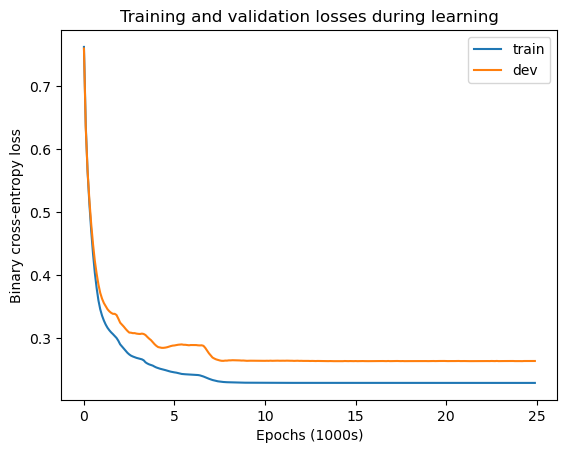

In [98]:
plt.plot(train_losses, label = 'train');
plt.plot(dev_losses, label = 'dev');
plt.title('Training and validation losses during learning');
plt.xlabel('Epochs (1000s)');
plt.xticks([0, 50, 100, 150, 200, 250], [0, 5, 10, 15, 20, 25]);
plt.ylabel('Binary cross-entropy loss');
plt.legend();

### Variance and bias

Looking at the plot above, we can see rapid learning towards the beginning, which later slows down and then seems to tail off. The split between the training and validation losses is an indication of overfitting - the model is doing better on the data it was trained on than on the data it hadn't seen. Overfitting is also known as varience - that s, how does the performance of the model vary with different sets of data. We can use the difference between the validation and training losses as a proxy for the overfitting. 

In somewhat of an oppoisition of varience exists bias, which roughly speaking is a measure of the overall performance of the model. A model with a high train loss but a low difference between train and dev is said to be a high-bias model - it generalises well but does generally poorly. Conversely, a model that does well on its train set but less so on its validation (i.e., the difference between the losses is greater than the train loss) is said to be high varience. Naturally, we aim at a model with both low bias and low variance. However, in many cases there is a trade-off between the two. Notably, a model could be simultaneously high-bias and high-variance - this would be considered a very bad model.

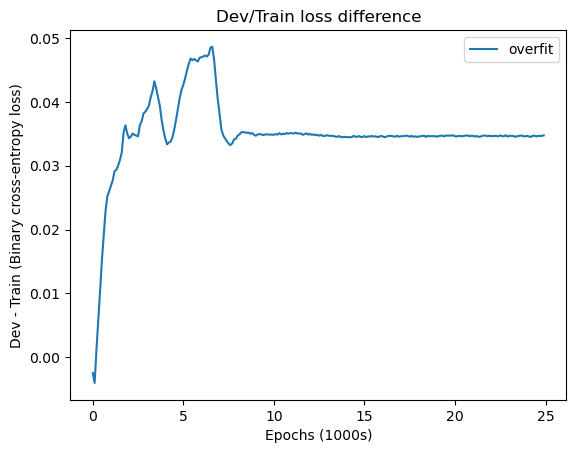

In [99]:
overfit = [dev_losses[i] - train_losses[i] for i in range(len(train_losses))]
plt.plot(overfit, label = 'overfit');
plt.title('Dev/Train loss difference');
plt.xlabel('Epochs (1000s)');
plt.xticks([0, 50, 100, 150, 200, 250], [0, 5, 10, 15, 20, 25]);
plt.ylabel('Dev - Train (Binary cross-entropy loss)');
plt.legend();

We can see that for our case, the overfitting isn't as severe. We can conclude that our model's bigger problem is its bias - that is, it cannot learn a function complex enough to deal with the task.

In [100]:
trains, vals = [], []
idx = dev_losses.index(min(dev_losses))
print(f"Minimal validation loss is at epoch {idx*100}: {dev_losses[idx]:.4f}")
print(f"Train loss at that epoch: {train_losses[idx]:.4f}")
print(f"Overfit/Train: {((dev_losses[idx]-train_losses[idx])/train_losses[idx]):.4f}")
vals.append(dev_losses[idx])
trains.append(train_losses[idx])

Minimal validation loss is at epoch 14200: 0.2637
Train loss at that epoch: 0.2293
Overfit/Train: 0.1503


### Making the model bigger

One way to improve the bias of a model is to make it bigger. This allows it to learn a more complex function that can better deal with the classification task. However, this also leaves more room for overfitting - here, bias and variance are somewhat of a trade-off.

To keep our model architectures shallow, for the time being we will only be tweaking the number of neurons in the first layer. Increasing them could potentially help us get lower bias, but also opens the door to higher varience. Let's find out!

In [101]:
# Slightly wider shallow model

A2 = nn.Sequential(
    nn.Linear(MAX_LEN, 24),
    nn.ReLU(),
    nn.Linear(24, 1),
    nn.Sigmoid()
    )

optimizer_A2 = torch.optim.Adam(A2.parameters())
A2.train=True

In [ ]:
MAX_EPOCHS = 30000
train_losses_A2, dev_losses_A2 = [], []
for epoch in range(MAX_EPOCHS):
    outs = A2(Xtr)
    loss = F.binary_cross_entropy(outs, Ytr)
    optimizer_A2.zero_grad()
    loss.backward()
    optimizer_A2.step()

    if epoch % 100 == 0:
        train_losses_A2.append(loss.item())
        with torch.no_grad():
            dev_pred = A2(Xdev)
            dev_loss = F.binary_cross_entropy(dev_pred, Ydev)
            dev_losses_A2.append(dev_loss.item())

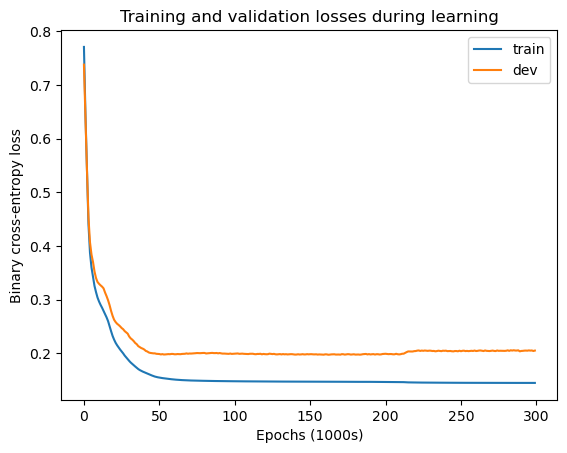

In [103]:
plt.plot(train_losses_A2, label = 'train');
plt.plot(dev_losses_A2, label = 'dev');
plt.title('Training and validation losses during learning');
plt.xlabel('Epochs (1000s)');
#plt.xticks([0, 50, 100, 150, 200, 250], [0, 5, 10, 15, 20, 25]);
plt.ylabel('Binary cross-entropy loss');
plt.legend();

In [104]:
idx = dev_losses_A2.index(min(dev_losses_A2))
print(f"Minimal validation loss is at epoch {idx*100}: {dev_losses_A2[idx]:.4f}")
print(f"Train loss at that epoch: {train_losses_A2[idx]:.4f}")
print(f"Overfit/Train: {((dev_losses_A2[idx]-train_losses_A2[idx])/train_losses_A2[idx]):.4f}")
vals.append(dev_losses_A2[idx])
trains.append(train_losses_A2[idx])


Minimal validation loss is at epoch 16200: 0.1972
Train loss at that epoch: 0.1469
Overfit/Train: 0.3425


We can see that we are getting lower losses, but more overfitting - we have "traded" lower bias for higher variance.

In [105]:
# Even wider shallow model

A3 = nn.Sequential(
    nn.Linear(MAX_LEN, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
    )

optimizer_A3 = torch.optim.Adam(A3.parameters())
A3.train=True
train_losses_A3, dev_losses_A3 = [], []

In [ ]:
MAX_EPOCHS = 30000

for epoch in range(MAX_EPOCHS):
    outs = A3(Xtr)
    loss = F.binary_cross_entropy(outs, Ytr)
    optimizer_A3.zero_grad()
    loss.backward()
    optimizer_A3.step()

    if epoch % 100 == 0:
        train_losses_A3.append(loss.item())
        with torch.no_grad():
            dev_pred = A3(Xdev)
            dev_loss = F.binary_cross_entropy(dev_pred, Ydev)
            dev_losses_A3.append(dev_loss.item())

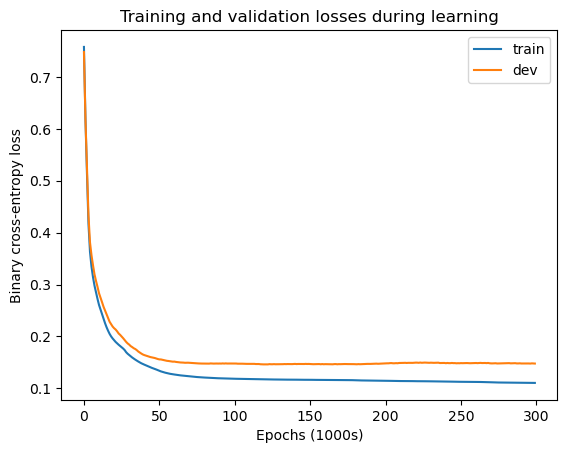

In [107]:
plt.plot(train_losses_A3, label = 'train');
plt.plot(dev_losses_A3, label = 'dev');
plt.title('Training and validation losses during learning');
plt.xlabel('Epochs (1000s)');
#plt.xticks([0, 50, 100, 150, 200, 250], [0, 5, 10, 15, 20, 25]);
plt.ylabel('Binary cross-entropy loss');
plt.legend();

In [108]:
idx = dev_losses_A3.index(min(dev_losses_A3))
print(f"Minimal validation loss is at epoch {idx*100}: {dev_losses_A3[idx]:.4f}")
print(f"Train loss at that epoch: {train_losses_A3[idx]:.4f}")
print(f"Overfit/Train: {((dev_losses_A3[idx]-train_losses_A3[idx])/train_losses_A3[idx]):.4f}")
vals.append(dev_losses_A3[idx])
trains.append(train_losses_A3[idx])

Minimal validation loss is at epoch 12200: 0.1462
Train loss at that epoch: 0.1173
Overfit/Train: 0.2466


In [109]:
# Widest shallow model

A4 = nn.Sequential(
    nn.Linear(MAX_LEN, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
    )

optimizer_A4 = torch.optim.Adam(A4.parameters())
A4.train=True
train_losses_A4, dev_losses_A4 = [], []

In [ ]:
MAX_EPOCHS = 25000
for epoch in range(MAX_EPOCHS):
    outs = A4(Xtr)
    loss = F.binary_cross_entropy(outs, Ytr)
    optimizer_A4.zero_grad()
    loss.backward()
    optimizer_A4.step()

    if epoch % 100 == 0:
        train_losses_A4.append(loss.item())
        with torch.no_grad():
            dev_pred = A4(Xdev)
            dev_loss = F.binary_cross_entropy(dev_pred, Ydev)
            dev_losses_A4.append(dev_loss.item())

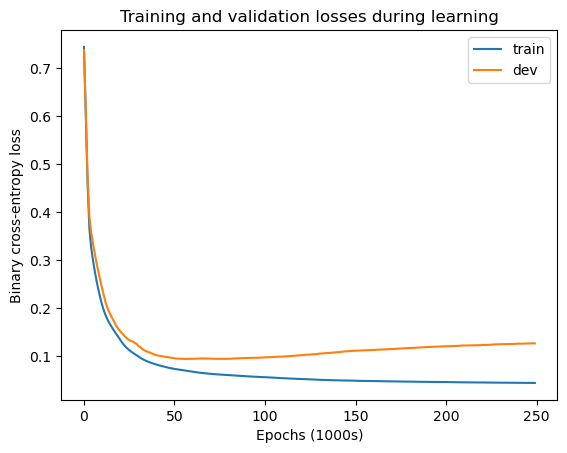

In [111]:
plt.plot(train_losses_A4, label = 'train');
plt.plot(dev_losses_A4, label = 'dev');
plt.title('Training and validation losses during learning');
plt.xlabel('Epochs (1000s)');
#plt.xticks([0, 50, 100, 150, 200, 250], [0, 5, 10, 15, 20, 25]);
plt.ylabel('Binary cross-entropy loss');
plt.legend();

In [112]:
idx = dev_losses_A4.index(min(dev_losses_A4))
print(f"Minimal validation loss is at epoch {idx*100}: {dev_losses_A4[idx]:.4f}")
print(f"Train loss at that epoch: {train_losses_A4[idx]:.4f}")
print(f"Overfit/Train: {((dev_losses_A4[idx]-train_losses_A4[idx])/train_losses_A4[idx]):.4f}")
vals.append(dev_losses_A4[idx])
trains.append(train_losses_A4[idx])

Minimal validation loss is at epoch 5500: 0.0936
Train loss at that epoch: 0.0700
Overfit/Train: 0.3379


### Dealing with high varience - dropout regularization

In [113]:
# Wide with dropout
 
A5 = nn.Sequential(
    nn.Linear(MAX_LEN, 64),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
    )

optimizer_A5 = torch.optim.Adam(A5.parameters())
A5.train=True
train_losses_A5, dev_losses_A5 = [], []

In [ ]:
MAX_EPOCHS = 25000
for epoch in range(MAX_EPOCHS):
    outs = A5(Xtr)
    loss = F.binary_cross_entropy(outs, Ytr)
    optimizer_A5.zero_grad()
    loss.backward()
    optimizer_A5.step()

    if epoch % 100 == 0:
        train_losses_A5.append(loss.item())
        with torch.no_grad():
            dev_pred = A5(Xdev)
            dev_loss = F.binary_cross_entropy(dev_pred, Ydev)
            dev_losses_A5.append(dev_loss.item())

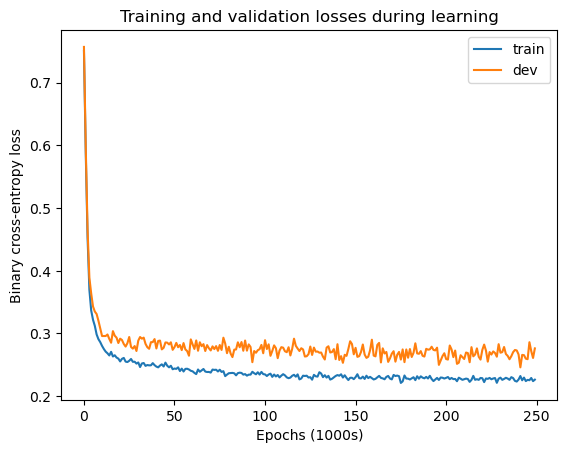

In [115]:
plt.plot(train_losses_A5, label = 'train');
plt.plot(dev_losses_A5, label = 'dev');
plt.title('Training and validation losses during learning');
plt.xlabel('Epochs (1000s)');
#plt.xticks([0, 50, 100, 150, 200, 250], [0, 5, 10, 15, 20, 25]);
plt.ylabel('Binary cross-entropy loss');
plt.legend();

In [116]:
idx = dev_losses_A5.index(min(dev_losses_A5))
print(f"Minimal validation loss is at epoch {idx*100}: {dev_losses_A5[idx]:.4f}")
print(f"Train loss at that epoch: {train_losses_A5[idx]:.4f}")
print(f"Overfit/Train: {((dev_losses_A5[idx]-train_losses_A5[idx])/train_losses_A5[idx]):.4f}")
vals.append(dev_losses_A5[idx])
trains.append(train_losses_A5[idx])

Minimal validation loss is at epoch 24100: 0.2460
Train loss at that epoch: 0.2321
Overfit/Train: 0.0597


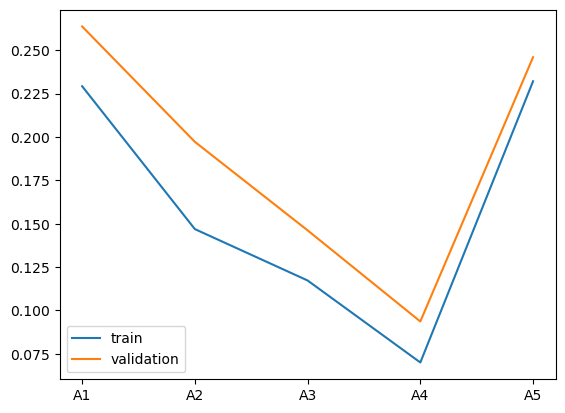

In [117]:
plt.plot(range(5), trains, label='train');
plt.plot(range(5), vals, label='validation');
plt.xticks([0, 1, 2, 3, 4], ['A1', 'A2', 'A3', 'A4', 'A5']);
plt.legend();

In [125]:
count_parameters(A4)

769

## Model B - Deeper neural network

In [132]:
B1 = nn.Sequential(
    nn.Linear(MAX_LEN, 32),
    nn.ReLU(),
    nn.Linear(32, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
    )

optimizer_B1 = torch.optim.Adam(B1.parameters())
B1.train=True
train_losses_B1, dev_losses_B1 = [], []

In [133]:
count_parameters(B1)

625

In [ ]:
MAX_EPOCHS = 25000
for epoch in range(MAX_EPOCHS):
    outs = B1(Xtr)
    loss = F.binary_cross_entropy(outs, Ytr)
    optimizer_B1.zero_grad()
    loss.backward()
    optimizer_B1.step()

    if epoch % 100 == 0:
        train_losses_B1.append(loss.item())
        with torch.no_grad():
            dev_pred = B1(Xdev)
            dev_loss = F.binary_cross_entropy(dev_pred, Ydev)
            dev_losses_B1.append(dev_loss.item())

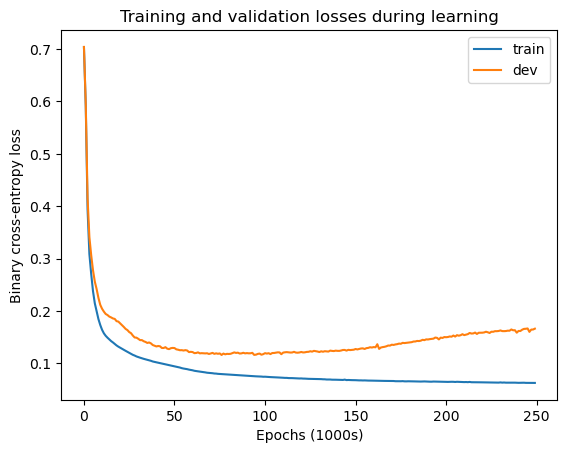

In [135]:
plt.plot(train_losses_B1, label = 'train');
plt.plot(dev_losses_B1, label = 'dev');
plt.title('Training and validation losses during learning');
plt.xlabel('Epochs (1000s)');
#plt.xticks([0, 50, 100, 150, 200, 250], [0, 5, 10, 15, 20, 25]);
plt.ylabel('Binary cross-entropy loss');
plt.legend();

In [136]:
idx = dev_losses_B1.index(min(dev_losses_B1))
print(f"Minimal validation loss is at epoch {idx*100}: {dev_losses_B1[idx]:.4f}")
print(f"Train loss at that epoch: {train_losses_B1[idx]:.4f}")
print(f"Overfit/Train: {((dev_losses_B1[idx]-train_losses_B1[idx])/train_losses_B1[idx]):.4f}")

Minimal validation loss is at epoch 7600: 0.1163
Train loss at that epoch: 0.0798
Overfit/Train: 0.4577
